# (1) Preprocessing Dataset

Make sure dataset file are in correct location.
run preprocess.py

In [1]:
from data.LDA import preprocess_text
from train.saving import save_model_results
from model.mf import MF_Bias, LDANet
from model.utility import RMSELoss


import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
import gc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from train.saving import save_model_results
from skorch import NeuralNetRegressor

In [2]:
subsets = {
        "Toys_and_Games_5.json",
        "Apps_for_Android_5.json",
        "Health_and_Personal_Care_5.json",
    }
pth = os.getcwd()[:-4]
NUM_TOPICS = 10
#preprocess_text(dataset=subsets, pth=pth, n_topics=NUM_TOPICS)
print(pth)

/Users/jb/Documents/GitHub/Intro ML (Nick Pang) Repository/rl-recommender


In [3]:
TG5_df = pd.read_json(os.path.join(pth, "datasets", "raw","Toys_and_Games_5.json"), lines=True)
AA5_df = pd.read_json(os.path.join(pth, "datasets", "raw", "Apps_for_Android_5.json"), lines=True)
HPC_df = pd.read_json(os.path.join(pth, "datasets", "raw", "Health_and_Personal_Care_5.json"), lines=True)

df = pd.concat([TG5_df, AA5_df, HPC_df], axis=0)
del TG5_df, AA5_df, HPC_df

In [4]:
# Keep essentials only
df = df[['reviewerID', 'asin', 'overall']]

# Map values
user_dict = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "user_mappings.csv"))
item_dict = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "item_mappings.csv"))
user_dict = dict(zip(user_dict.iloc[:, 1], user_dict.index))
item_dict = dict(zip(item_dict.iloc[:, 1], item_dict.index))

df['reviewerID'] = df['reviewerID'].map(user_dict).fillna(df['reviewerID'])
df['asin'] = df['asin'].map(item_dict).fillna(df['asin'])

df[['reviewerID', 'asin']] = df[['reviewerID', 'asin']].astype(int)
df['overall'] = df['overall'].astype(float)

print(df)

        reviewerID   asin  overall
0           124394  31743      5.0
1           124395  31743      4.0
2           124396  31743      5.0
3           124397  31743      5.0
4           124398  31743      4.0
...            ...    ...      ...
346350       29878  18533      5.0
346351       37951  18533      5.0
346352       36501  18533      5.0
346353       36040  18533      5.0
346354       36504  18533      5.0

[1266889 rows x 3 columns]


In [5]:
m = df['overall'].mean()
np.savez_compressed(os.path.join(pth, "datasets", "processed", "Subset_5core_PreprocessLDA.npz"),
                    x = df[['reviewerID', 'asin']],
                    y = df['overall'],
                    u_size = len(user_dict),
                    i_size = len(item_dict),
                    m = m)

# (2) Create Model

This model doesn't use internal LDA YET!

### I wanted to test running on Apple Silicon Chips

In [6]:
device = torch.device('mps' if torch.has_mps else 'cpu')
f_type = torch.float32 if device.type == 'mps' else torch.float64
print(f"device_type: {device}")
print(f"float_type: {f_type}")

device_type: mps
float_type: torch.float32


In [7]:
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
EPOCHS = 15
DECAY = 1e-3
DROPOUT = 0.4

In [8]:
gc.collect()

data = np.load(os.path.join(pth, "datasets", "processed", "Subset_5core_PreprocessLDA.npz"))
x = data['x']
y = data['y']
U_size = data['u_size']
I_size = data['i_size']
G_b = data['m']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
y_train, y_test = torch.tensor(y_train, dtype = f_type).to(device), torch.tensor(y_test, dtype = f_type).to(device)

loss_fn = RMSELoss()
optimizer = Adam

### I am adding the class here only so I append **.to(*device*)** for each tensor

In [9]:
class MF(nn.Module):
    def __init__(self, n_users, n_items, K, dropout=0):
        super().__init__()
        self.user_m = nn.Embedding(
            n_users, K, dtype=f_type
        ).to(device)  # can include option sparse = True for memory
        self.item_m = nn.Embedding(n_items, K, dtype=f_type).to(device)
        self.drop_u = nn.Dropout(dropout)
        self.drop_i = nn.Dropout(dropout)

    def forward(self, x):
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        user_embeds = self.drop_u(self.user_m(user_ids))
        item_embeds = self.drop_i(self.item_m(item_ids))
        prod = user_embeds * item_embeds

        out = torch.sum(prod, 1)

        return out


# Matrix factorization with user/item biases
class MF_Bias(MF):
    def __init__(self, n_users, n_items, K, G_b, dropout=0):
        super().__init__(n_users, n_items, K, dropout)

        self.user_b = nn.Embedding(n_users, 1, dtype=f_type).to(device)
        self.item_b = nn.Embedding(n_items, 1, dtype=f_type).to(device)
        nn.init.zeros_(self.user_b.weight)
        nn.init.zeros_(self.item_b.weight)

        self.G_b = torch.from_numpy(G_b)

    def forward(self, x):
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        out = super().forward(x)

        user_biases = self.user_b(user_ids).squeeze()
        item_biases = self.item_b(item_ids).squeeze()

        out += user_biases + item_biases + self.G_b

        return out

In [10]:
model = MF_Bias(U_size, I_size, NUM_TOPICS, G_b, DROPOUT)

In [11]:
user_map = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "user_topics.csv"))
for idx,row  in user_map.iterrows():
    row = row[1:] # to remove 'User_ID' from row
    model.user_m.weight.data[idx] = torch.tensor(row.values, dtype=f_type).to(device)

item_map = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "item_topics.csv"))
for idx,row  in item_map.iterrows():
    row = row[1:] # to remove 'Item_ID' from row
    model.item_m.weight.data[idx] = torch.tensor(row.values, dtype=f_type).to(device)

# (3) Run Model

In [12]:
regressor = NeuralNetRegressor(
    model,
    criterion = loss_fn,
    optimizer = optimizer,
    optimizer__param_groups = [
        ('user_m.weight', {'weight_decay': DECAY}),
        ('item_m.weight', {'weight_decay': DECAY})
    ],
    optimizer__lr = LEARNING_RATE,
    batch_size = BATCH_SIZE,
    max_epochs = EPOCHS
)
gc.collect()

0

### Borrowed from *save_model_results()*

In [14]:
results = regressor.fit(x_train, y_train)
history = results.history

tr_losses = [i['train_loss'] for i in history]
t_losses = [i['valid_loss'] for i in history]

with open(os.path.join(pth, "results", f"model_PreprocessingLDA_{device}_{f_type}.pkl"), 'wb') as f:
    pickle.dump(model, f)

np.savez_compressed(os.path.join(pth, "results", f"Both_MPBais_PreprocessLDA_{device}_{f_type}.npz"),
                    tr_loss = tr_losses,
                    t_loss = t_losses)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        1.1896        1.1802  109.1130
      2        1.1489        1.1594  110.3560
      3        1.1194        1.1461  115.2408
      4        1.0970        1.1372  109.3161
      5        1.0792        1.1309  107.9566
      6        1.0646        1.1265  101.8752
      7        1.0524        1.1233  95.2898
      8        1.0420        1.1211  84.7460
      9        1.0331        1.1195  84.3467
     10        1.0254        1.1184  84.7126
     11        1.0185        1.1177  84.6746
     12        1.0125        1.1174  83.7785
     13        1.0071        1.1173  84.7701
     14        1.0023        1.1174  85.1043
     15        0.9980        1.1176  84.2645


### Another Model without setting the weights

In [15]:
model = MF_Bias(U_size, I_size, NUM_TOPICS, G_b, DROPOUT)

In [16]:
regressor = NeuralNetRegressor(
    model,
    criterion = loss_fn,
    optimizer = optimizer,
    optimizer__param_groups = [
        ('user_m.weight', {'weight_decay': DECAY}),
        ('item_m.weight', {'weight_decay': DECAY})
    ],
    optimizer__lr = LEARNING_RATE,
    batch_size = BATCH_SIZE,
    max_epochs = EPOCHS
)
gc.collect()

0

In [17]:
results = regressor.fit(x_train, y_train)
history = results.history

tr_losses = [i['train_loss'] for i in history]
t_losses = [i['valid_loss'] for i in history]

with open(os.path.join(pth, "results", f"model_PreprocessingLDA_{device}_{f_type}.pkl"), 'wb') as f:
    pickle.dump(model, f)

np.savez_compressed(os.path.join(pth, "results", f"MPBais_Baseline_{device}_{f_type}.npz"),
                    tr_loss = tr_losses,
                    t_loss = t_losses)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        1.5809        1.1981  90.7385
      2        1.1700        1.1699  94.3932
      3        1.1345        1.1528  97.1234
      4        1.1085        1.1416  96.4786
      5        1.0883        1.1340  96.4588
      6        1.0720        1.1287  98.6336
      7        1.0586        1.1249  91.7633
      8        1.0473        1.1221  97.7357
      9        1.0377        1.1202  94.0399
     10        1.0293        1.1188  98.4639
     11        1.0220        1.1180  93.0571
     12        1.0156        1.1174  94.4875
     13        1.0099        1.1172  95.7955
     14        1.0048        1.1172  96.1090
     15        1.0002        1.1174  93.5907


### Only Preprocessed Users & Only Items

In [22]:
model_users = MF_Bias(U_size, I_size, NUM_TOPICS, G_b, DROPOUT)
model_items = MF_Bias(U_size, I_size, NUM_TOPICS, G_b, DROPOUT)

In [23]:
user_map = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "user_topics.csv"))
for idx,row  in user_map.iterrows():
    row = row[1:] # to remove 'User_ID' from row
    model_users.user_m.weight.data[idx] = torch.tensor(row.values, dtype=f_type).to(device)

item_map = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "item_topics.csv"))
for idx,row  in item_map.iterrows():
    row = row[1:] # to remove 'Item_ID' from row
    model_items.item_m.weight.data[idx] = torch.tensor(row.values, dtype=f_type).to(device)

In [24]:
regressor_users = NeuralNetRegressor(
    model_users,
    criterion = loss_fn,
    optimizer = optimizer,
    optimizer__param_groups = [
        ('user_m.weight', {'weight_decay': DECAY}),
        ('item_m.weight', {'weight_decay': DECAY})
    ],
    optimizer__lr = LEARNING_RATE,
    batch_size = BATCH_SIZE,
    max_epochs = EPOCHS
)
regressor_items = NeuralNetRegressor(
    model_items,
    criterion = loss_fn,
    optimizer = optimizer,
    optimizer__param_groups = [
        ('user_m.weight', {'weight_decay': DECAY}),
        ('item_m.weight', {'weight_decay': DECAY})
    ],
    optimizer__lr = LEARNING_RATE,
    batch_size = BATCH_SIZE,
    max_epochs = EPOCHS
)

In [25]:
results = regressor_users.fit(x_train, y_train)
history = results.history

tr_losses = [i['train_loss'] for i in history]
t_losses = [i['valid_loss'] for i in history]

with open(os.path.join(pth, "results", f"model_PreprocessingLDA_{device}_{f_type}.pkl"), 'wb') as f:
    pickle.dump(model, f)

np.savez_compressed(os.path.join(pth, "results", f"Users_MPBais_{device}_{f_type}.npz"),
                    tr_loss = tr_losses,
                    t_loss = t_losses)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        1.2520        1.1956  96.2351
      2        1.1675        1.1687  93.7928
      3        1.1329        1.1521  92.3571
      4        1.1073        1.1412  92.6789
      5        1.0874        1.1337  92.9103
      6        1.0713        1.1285  94.3349
      7        1.0581        1.1247  94.1356
      8        1.0469        1.1220  94.6132
      9        1.0373        1.1201  93.7135
     10        1.0290        1.1188  93.4099
     11        1.0217        1.1180  94.1915
     12        1.0153        1.1175  94.1084
     13        1.0096        1.1172  94.8036
     14        1.0046        1.1172  94.8686
     15        1.0000        1.1174  94.7547


In [26]:
results = regressor_items.fit(x_train, y_train)
history = results.history

tr_losses = [i['train_loss'] for i in history]
t_losses = [i['valid_loss'] for i in history]

with open(os.path.join(pth, "results", f"model_PreprocessingLDA_{device}_{f_type}.pkl"), 'wb') as f:
    pickle.dump(model, f)

np.savez_compressed(os.path.join(pth, "results", f"Items_MPBais_Baseline_{device}_{f_type}.npz"),
                    tr_loss = tr_losses,
                    t_loss = t_losses)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        1.2613        1.1956  83.3967
      2        1.1676        1.1687  83.2045
      3        1.1330        1.1521  83.6538
      4        1.1074        1.1412  88.1941
      5        1.0874        1.1337  91.3011
      6        1.0714        1.1285  90.7779
      7        1.0581        1.1247  91.7139
      8        1.0469        1.1221  95.1239
      9        1.0373        1.1201  93.7496
     10        1.0290        1.1188  94.9438
     11        1.0217        1.1179  95.2125
     12        1.0153        1.1174  93.5900
     13        1.0097        1.1172  95.5732
     14        1.0046        1.1172  94.3999
     15        1.0001        1.1174  96.2268


# (4) Graphs

In [27]:
gc.collect()

0

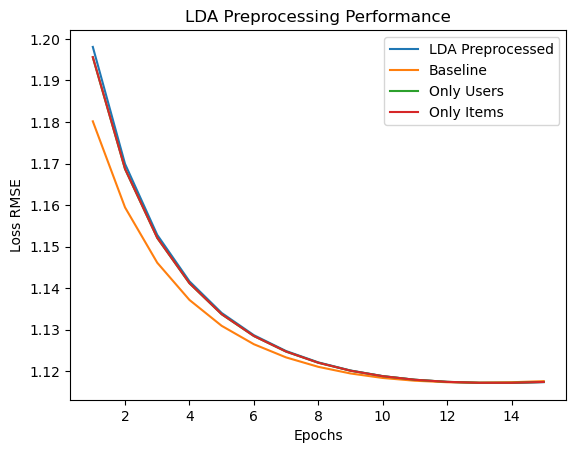

In [37]:
import matplotlib.pyplot as plt
p = np.load(os.path.join(pth, "results", f"Both_MPBais_Baseline_{device}_{f_type}.npz"))
not_p = np.load(os.path.join(pth, "results", f"MPBais_PreprocessLDA_{device}_{f_type}.npz"))
u = np.load(os.path.join(pth, "results", f"Users_MPBais_{device}_{f_type}.npz"))
i = np.load(os.path.join(pth, "results", f"Items_MPBais_Baseline_{device}_{f_type}.npz"))

plt.plot([i+1 for i in range(EPOCHS)], p['t_loss'], label='LDA Preprocessed')
plt.plot([i+1 for i in range(EPOCHS)], not_p['t_loss'], label='Baseline')
plt.plot([i+1 for i in range(EPOCHS)], u['t_loss'], label='Only Users')
plt.plot([i+1 for i in range(EPOCHS)], i['t_loss'], label='Only Items')
plt.xlabel('Epochs')
plt.ylabel('Loss RMSE')
plt.title('LDA Preprocessing Performance')
plt.legend()
plt.show()

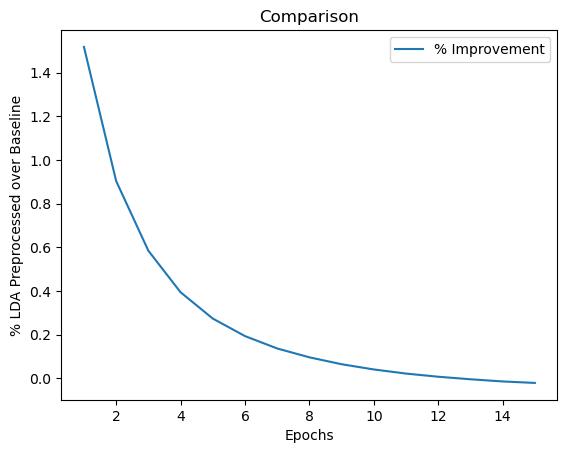

In [55]:
factor = list()
for i in range(len(p['t_loss'])):
    f = (100 *(float(p['t_loss'][i]) / float(not_p['t_loss'][i]))) - 100
    factor.append(f)

plt.plot([i+1 for i in range(EPOCHS)], factor, label='% Improvement')
plt.xlabel('Epochs')
plt.ylabel('% LDA Preprocessed over Baseline')
plt.title('Comparison')
plt.legend()
plt.show()